# ADZD Lab3 - Apache Spark Cluster
**Author: Bartłomiej Jamiołkowski**

To perform the task, use the Apache Spark cluster created on AWS Elastic Map Reduce: https://aws.amazon.com/emr

Dataset for analysis: OpenAQ https://registry.opendata.aws/openaq/ is available directly from AWS S3.

## Spark initialization

In [10]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql import functions as F
from pyspark.sql.window import Window

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type": "native",
        "spark.pyspark.virtualenv.bin.path": "/usr/bin/virtualenv"
    }
}

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1730752633254_0003,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1730752633254_0003,pyspark,idle,Link,Link,None,✔


In [4]:
# run once per session to install additional packages
sc.install_pypi_package('pandas')
sc.install_pypi_package('matplotlib')
sc.install_pypi_package('plotly')
sc.install_pypi_package('ipython')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Not uninstalling python-dateutil at /usr/lib/python3.9/site-packages, outside environment /mnt/yarn/usercache/livy/appcache/application_1730752633254_0003/container_1730752633254_0003_01_000001/tmp/spark-914b152a-7eda-4d6a-8433-01db287db16f
    Can't uninstall 'python-dateutil'. No files were found to uninstall.



  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 3.0.24
    Not uninstalling prompt-toolkit at /usr/lib/python3.9/site-packages, outside environment /mnt/yarn/usercache/livy/appcache/application_1730752633254_0003/container_1730752633254_0003_01_000001/tmp/spark-914b152a-7eda-4d6a-8433-01db287db16f
    Can't uninstall 'prompt-toolkit'. No files were found to uninstall.

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts

## Libraries

In [5]:
import numpy as np
import time
import plotly.express as px
from IPython.display import IFrame
import matplotlib.pyplot as plt
import pandas as pd

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Reading data from AWS S3

In [7]:
start = time.time()

smog_df = spark \
    .read \
    .format('csv') \
    .option('compression', 'gzip') \
    .option('header', True) \
    .load('s3a://openaq-data-archive/records/csv.gz/locationid=10*/year=2022/month=05/*.csv.gz')

end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

111.869389295578

In [8]:
# Further queries on smog_df will run much faster when we cache this data set in memory
smog_df.cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[location_id: string, sensors_id: string, location: string, datetime: string, lat: string, lon: string, parameter: string, units: string, value: string]

In [9]:
smog_df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- location_id: string (nullable = true)
 |-- sensors_id: string (nullable = true)
 |-- location: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lon: string (nullable = true)
 |-- parameter: string (nullable = true)
 |-- units: string (nullable = true)
 |-- value: string (nullable = true)

In [10]:
smog_df = smog_df.withColumn('value', smog_df.value.cast('double'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
smog_df = smog_df.withColumn('city', F.split(F.col('location'), ',').getItem(0))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
smog_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----------+--------------------+--------------------+---------+---------+---------+-----+-------+----------------+
|location_id|sensors_id|            location|            datetime|      lat|      lon|parameter|units|  value|            city|
+-----------+----------+--------------------+--------------------+---------+---------+---------+-----+-------+----------------+
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T01:00:...|50.349608|18.236575|     pm10|µg/m³|  15.62|Kędzierzyn-Koźle|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T02:00:...|50.349608|18.236575|     pm10|µg/m³|13.6041|Kędzierzyn-Koźle|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T03:00:...|50.349608|18.236575|     pm10|µg/m³|13.7349|Kędzierzyn-Koźle|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T04:00:...|50.349608|18.236575|     pm10|µg/m³|15.1872|Kędzierzyn-Koźle|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T05:00:...|50.349608|18.236575|     pm10|µg/m³|13

In [15]:
smog_7_days_df = smog_df.where(
    (F.col('datetime') >= F.lit('2022-05-03T01:00:00+02:00')) & (F.col('datetime') <  F.lit('2022-05-10T01:00:00+02:00'))
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Exercise 1

Find cities where the average concentration of “pm25” dust was lower than the maximum concentration in one selected city (over the entire studied period). Perform calculations for data from several days. Sort the results in descending order by pm25 concentration.

In [21]:
cracow_max_pm25 = (
    smog_7_days_df
    .where((F.col('city').rlike('Krak.w')) & (F.col('parameter') == 'pm25'))
    .select(F.max(F.col('value')))
    .head())[0]

cracow_max_pm25

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

46.1388

In [22]:
cities_with_lower_mean_pm25 = (
    smog_7_days_df
    .filter(F.col('parameter') == 'pm25')
    .select('city', 'value')
    .groupBy('city')
    .agg(F.mean('value').alias('mean_pm25_value'))
    .filter(F.col('mean_pm25_value') < cracow_max_pm25)
    .orderBy(F.desc('mean_pm25_value'))
)

cities_with_lower_mean_pm25.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|                city|   mean_pm25_value|
+--------------------+------------------+
|Padre Las Casas I...|          44.71875|
|     Industrial Area|44.487837837837844|
|      Manali Village| 42.83013513513514|
|           Samanpura| 42.73421052631579|
|             Ghusuri| 37.67486842105263|
|         Polayathode| 35.26595588235294|
|             Palayam| 34.80493150684932|
|             Murthal| 34.57976190476191|
|            Muradpur| 34.04473684210526|
|          Thavakkara| 31.86938461538461|
|      Railway Colony|           28.2416|
|          Vidayagiri|27.665396825396826|
|      Kalyana Nagara|27.399661016949157|
|            Racibórz|26.295487311827962|
|            Radomsko|25.233333333333334|
|         Kacheripady|24.972602739726028|
|         PWD Juction|              24.0|
|          Ballygunge|23.717333333333332|
|         Arica-10653|23.020833333333332|
|  Goczałkowice Zdrój|22.880531250000004|
+--------------------+------------

## Exercise 2

For data from selected several days, present in hourly terms (select UTC time) the highest recorded pm10 concentration from the entire data set along with the name of the city where this maximum concentration occurred. Sort the results by ascending dates.

In [23]:
smog_7_days_df_copy = smog_7_days_df.select('*') 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
smog_7_days_df_copy = smog_7_days_df_copy.withColumn('datetime', F.date_trunc('hour', F.to_utc_timestamp(F.col('datetime'), 'UTC')))
smog_7_days_df_copy.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----------+--------------------+-------------------+---------+---------+---------+-----+-------+----------------+
|location_id|sensors_id|            location|           datetime|      lat|      lon|parameter|units|  value|            city|
+-----------+----------+--------------------+-------------------+---------+---------+---------+-----+-------+----------------+
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-04 23:00:00|50.349608|18.236575|     pm10|µg/m³|33.6813|Kędzierzyn-Koźle|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-05 00:00:00|50.349608|18.236575|     pm10|µg/m³|35.8368|Kędzierzyn-Koźle|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-05 01:00:00|50.349608|18.236575|     pm10|µg/m³|34.8195|Kędzierzyn-Koźle|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-05 02:00:00|50.349608|18.236575|     pm10|µg/m³|35.1892|Kędzierzyn-Koźle|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-05 03:00:00|50.349608|18.236575|     pm10|µg/m³|35.0769|Kę

In [26]:
cities_max_pm10_per_hour = (
    smog_7_days_df_copy
    .filter(F.col('parameter') == 'pm10')
    .select('datetime', 'city', 'value')
    .groupBy('datetime')
    .agg(F.max('value').alias('max_pm10_value'), F.first('city').alias('city'))
    .orderBy('datetime')
)

cities_max_pm10_per_hour.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+--------------+---------------+
|           datetime|max_pm10_value|           city|
+-------------------+--------------+---------------+
|2022-05-02 15:00:00|          20.9|Dandenong-10868|
|2022-05-02 16:00:00|          20.8|Dandenong-10868|
|2022-05-02 17:00:00|          20.8|Dandenong-10868|
|2022-05-02 18:00:00|          20.8|Dandenong-10868|
|2022-05-02 19:00:00|         271.0|Dandenong-10868|
|2022-05-02 20:00:00|         571.6|Dandenong-10868|
|2022-05-02 21:00:00|         367.2|Dandenong-10868|
|2022-05-02 22:00:00|        511.93|  RO0079A-10808|
|2022-05-02 23:00:00|         125.0|        Wrocław|
|2022-05-03 00:00:00|         130.0|        Wrocław|
|2022-05-03 01:00:00|         126.0|        Wrocław|
|2022-05-03 02:00:00|          97.0|        Wrocław|
|2022-05-03 03:00:00|          96.0|        Wrocław|
|2022-05-03 04:00:00|         103.0|        Wrocław|
|2022-05-03 05:00:00|         108.8|        Wrocław|
|2022-05-03 06:00:00|         114.8|        Wr

## Exercise 3

Find the ranking of cities by average pollution calculated for the N highest “pm25” measurements for multiple days of data.

In [32]:
def get_polluted_cities_rank(n):
    window = Window.partitionBy('city').orderBy(F.desc('value'))
    
    rank_df = (
        smog_7_days_df
        .filter(F.col('parameter') == 'pm25')
        .withColumn('rank', F.row_number().over(window))
        .filter(F.col('rank') <= n)
        .groupBy('city')
        .agg(F.mean('value').alias(f'mean_pm25_top_{n}_measurements'))
        .sort(F.desc(f'mean_pm25_top_{n}_measurements'))
    )
    
    return rank_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
polluted_cities_rank = get_polluted_cities_rank(5)

polluted_cities_rank.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----------------------------+
|               city|mean_pm25_top_5_measurements|
+-------------------+----------------------------+
|New Industrial Town|           607.5400000000001|
|          Sector 11|          262.58000000000004|
|   Mini Secretariat|          247.85999999999996|
|        City Center|                       197.6|
|          Teri Gram|          196.64000000000001|
|                ITO|                       195.4|
|             Rohini|                       160.6|
|             Narela|                       159.0|
|             Mundka|                       156.8|
|          Najafgarh|                       124.4|
|        Rishi Nagar|          119.08600000000001|
|          Sector-51|          111.94200000000001|
| Sri Aurobindo Marg|                       111.4|
|       Sanjay Nagar|                       101.4|
|        Civil Lines|           99.82000000000001|
|     Rajbansi Nagar|                       99.82|
|          Sector-12|          

## Exercise 4

Visualize on a map the average pollution of selected cities for several selected days over time (map + time slider or a set of frames and animation)

In [51]:
cities_pl = ['Warszawa', 'Wroc.aw', 'Krak.w', 'Pozna.', 'Gda.sk', 'Lublin', 'Bia.ystok']

cities_pl_regex = '|'.join(cities_pl)
cities_window = Window.partitionBy('city').orderBy('date')

cities_mean_pm25 = (
    smog_7_days_df
    .select('city', 'datetime', 'lat', 'lon', 'value')
    .na.drop()
    .where(
        (F.col('parameter') == 'pm25') &
        (F.col('city').rlike(cities_pl_regex))
    )
    .withColumn('date', F.to_date(F.col('datetime')))
    .withColumn('lat', F.first('lat').over(cities_window))
    .withColumn('lon', F.first('lon').over(cities_window))
    .groupBy('city', 'date')
    .agg(
        F.avg('value').alias('mean_value_pm25'),
        F.first('lat').alias('lat'),
        F.first('lon').alias('lon')
    )
    .orderBy('city', 'date')
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
cities_mean_pm25.show(56)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+----------+------------------+---------+---------+
|     city|      date|   mean_value_pm25|      lat|      lon|
+---------+----------+------------------+---------+---------+
|Białystok|2022-05-03|15.608695652173912|53.126689|23.155869|
|Białystok|2022-05-04|               5.0|53.126689|23.155869|
|Białystok|2022-05-05| 8.391304347826088|53.126689|23.155869|
|Białystok|2022-05-06|              21.0|53.126689|23.155869|
|Białystok|2022-05-07| 15.26086956521739|53.126689|23.155869|
|Białystok|2022-05-08|              27.0|53.126689|23.155869|
|Białystok|2022-05-09| 6.130434782608695|53.126689|23.155869|
|Białystok|2022-05-10|              11.0|53.126689|23.155869|
|   Gdańsk|2022-05-03|10.633483478260871|54.380279|18.620274|
|   Gdańsk|2022-05-04|10.420796666666668|54.380279|18.620274|
|   Gdańsk|2022-05-05|18.605477424242423|54.380279|18.620274|
|   Gdańsk|2022-05-06|27.186266666666665|54.380279|18.620274|
|   Gdańsk|2022-05-07|13.067539420289851|54.380279|18.620274|
|   Gdań

In [52]:
cities_mean_pm25 = cities_mean_pm25.toPandas()
cities_mean_pm25['label'] = cities_mean_pm25['city'] + '<br>' + cities_mean_pm25['mean_value_pm25'].round(2).astype(str)

custom_colorscale = [
    [0, 'green'],
    [0.04, 'yellow'],
    [0.16, 'orange'],
    [0.25, 'red'],
    [0.56, 'darkviolet'],
    [1.0, 'purple']
]

fig = px.scatter_geo(
    cities_mean_pm25,
    lat='lat',
    lon='lon',
    color='mean_value_pm25',
    size='mean_value_pm25',
    animation_frame='date',
    title='Air Quality in Selected Polish Cities over Time',
    scope='europe',
    color_continuous_scale=custom_colorscale,
    range_color=[0.0, 225.5],
    text = 'label'
)

fig.update_geos(
    center=dict(lat=52.188474, lon=21.176233),
    projection_scale=6
)

fig.update_layout(
    width = 800,
    height = 800,
    margin = {'r': 0, 't': 50, 'l': 0, 'b': 0}
)

fig.update_traces(textposition = 'top center', textfont_size = 10)
fig.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [60]:
fig.write_html('animation_ex_4.html')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
IFrame('animation_ex_4.html', width = 800, height = 600)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
%%html
<iframe src = 'animation_ex_4.html' width = '900' height = '900'></iframe>

## Exercise 5

Using a cluster for large data<br>
a. Please perform task 1 for data of such a size that the query time is at least 10 minutes. Measure the execution time.

In [17]:
start = time.time()

smog_year_df = spark \
    .read \
    .format("csv") \
    .option("compression", "gzip") \
    .option("header", True) \
    .load("s3a://openaq-data-archive/records/csv.gz/locationid=10*/year=2022/month=*/*.csv.gz")
    #.load("s3a://openaq-data-archive/records/csv.gz/locationid=2178/year=2022/month=05/location-2178-20220503.csv.gz")\

end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

935.2330300807953

In [18]:
smog_year_df = smog_year_df.withColumn('value', smog_year_df.value.cast('double'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
smog_year_df = smog_year_df.withColumn('city', F.split(F.col('location'), ',').getItem(0))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
start = time.time()

cracow_max_pm25 = (
    smog_year_df
    .where((F.col('city').rlike('Krak.w')) & (F.col('parameter') == 'pm25'))
    .select(F.max(F.col('value')))
    .head())[0]

cracow_max_pm25

cities_with_lower_mean_pm25 = (
    smog_year_df
    .filter(F.col('parameter') == 'pm25')
    .select('city', 'value')
    .groupBy('city')
    .agg(F.mean('value').alias('mean_pm25_value'))
    .filter(F.col('mean_pm25_value') < cracow_max_pm25)
    .orderBy(F.desc('mean_pm25_value'))
)

end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

992.8414256572723

b. Increase the cluster to 2, 3, 4, 5, 6, 7 worker instances and measure the execution times.

In [26]:
start = time.time()

cracow_max_pm25 = (
    smog_year_df
    .where((F.col('city').rlike('Krak.w')) & (F.col('parameter') == 'pm25'))
    .select(F.max(F.col('value')))
    .head())[0]

cracow_max_pm25

cities_with_lower_mean_pm25 = (
    smog_year_df
    .filter(F.col('parameter') == 'pm25')
    .select('city', 'value')
    .groupBy('city')
    .agg(F.mean('value').alias('mean_pm25_value'))
    .filter(F.col('mean_pm25_value') < cracow_max_pm25)
    .orderBy(F.desc('mean_pm25_value'))
)

end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

152.10819268226624

In [27]:
workers = np.arange(1, 8)
execution_times = np.array([992.84, 554.74, 394.07, 277.26, 218.13, 175.47, 152.11])
speedups = execution_times[0] / execution_times
efficiencies = speedups / workers

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

c. Draw plots of time, speedup, efficiency.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

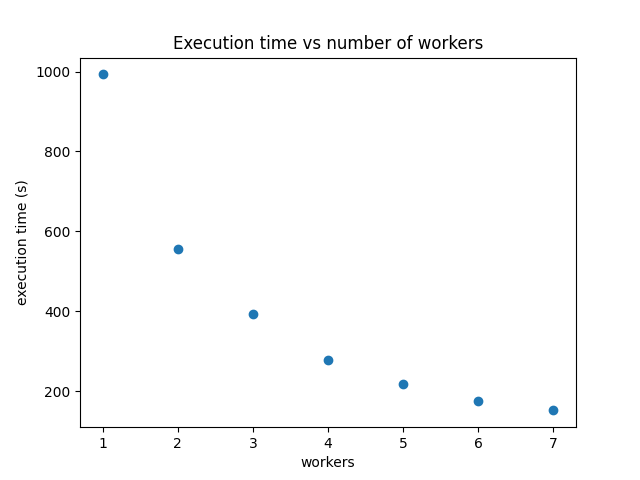

In [28]:
plt.scatter(workers, execution_times)
plt.xlabel('workers')
plt.ylabel('execution time (s)')
plt.title('Execution time vs number of workers')
plt.show()
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

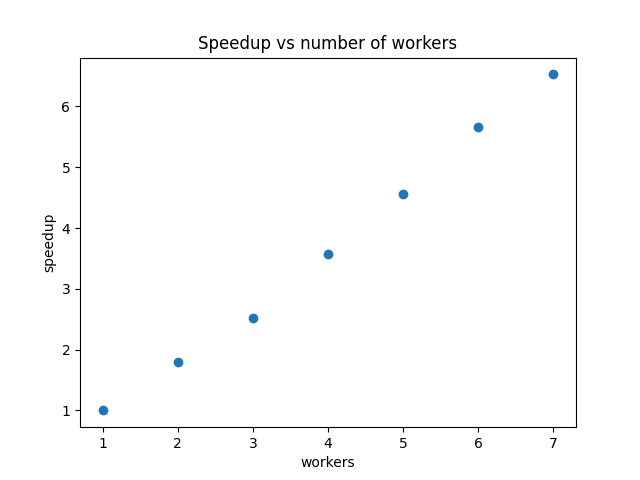

In [29]:
plt.clf()
plt.scatter(workers, speedups)
plt.xlabel('workers')
plt.ylabel('speedup')
plt.title('Speedup vs number of workers')
plt.show()
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

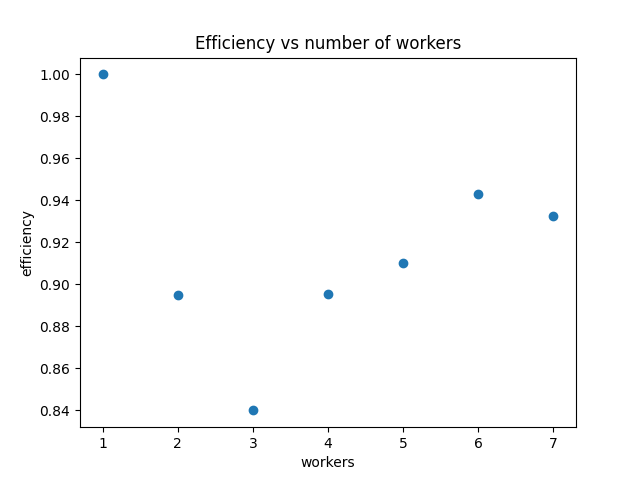

In [30]:
plt.clf()
plt.scatter(workers, efficiencies)
plt.xlabel('workers')
plt.ylabel('efficiency')
plt.title('Efficiency vs number of workers')
plt.show()
%matplot plt

## Exercise 6

For the sample query, attach selected charts from Spark UI (https://spark.apache.org/docs/latest/web-ui.html), e.g. DAG, Gantt chart, data size information.

In [20]:
cracow_max_pm10 = (
    smog_7_days_df
    .where((F.col('city').rlike('Krak.w')) & (F.col('parameter') == 'pm10'))
    .select(F.max(F.col('value')))
    .head())[0]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

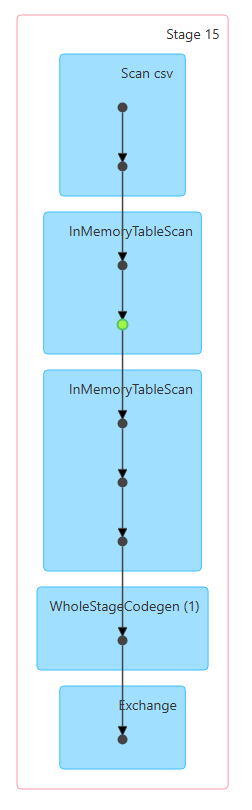

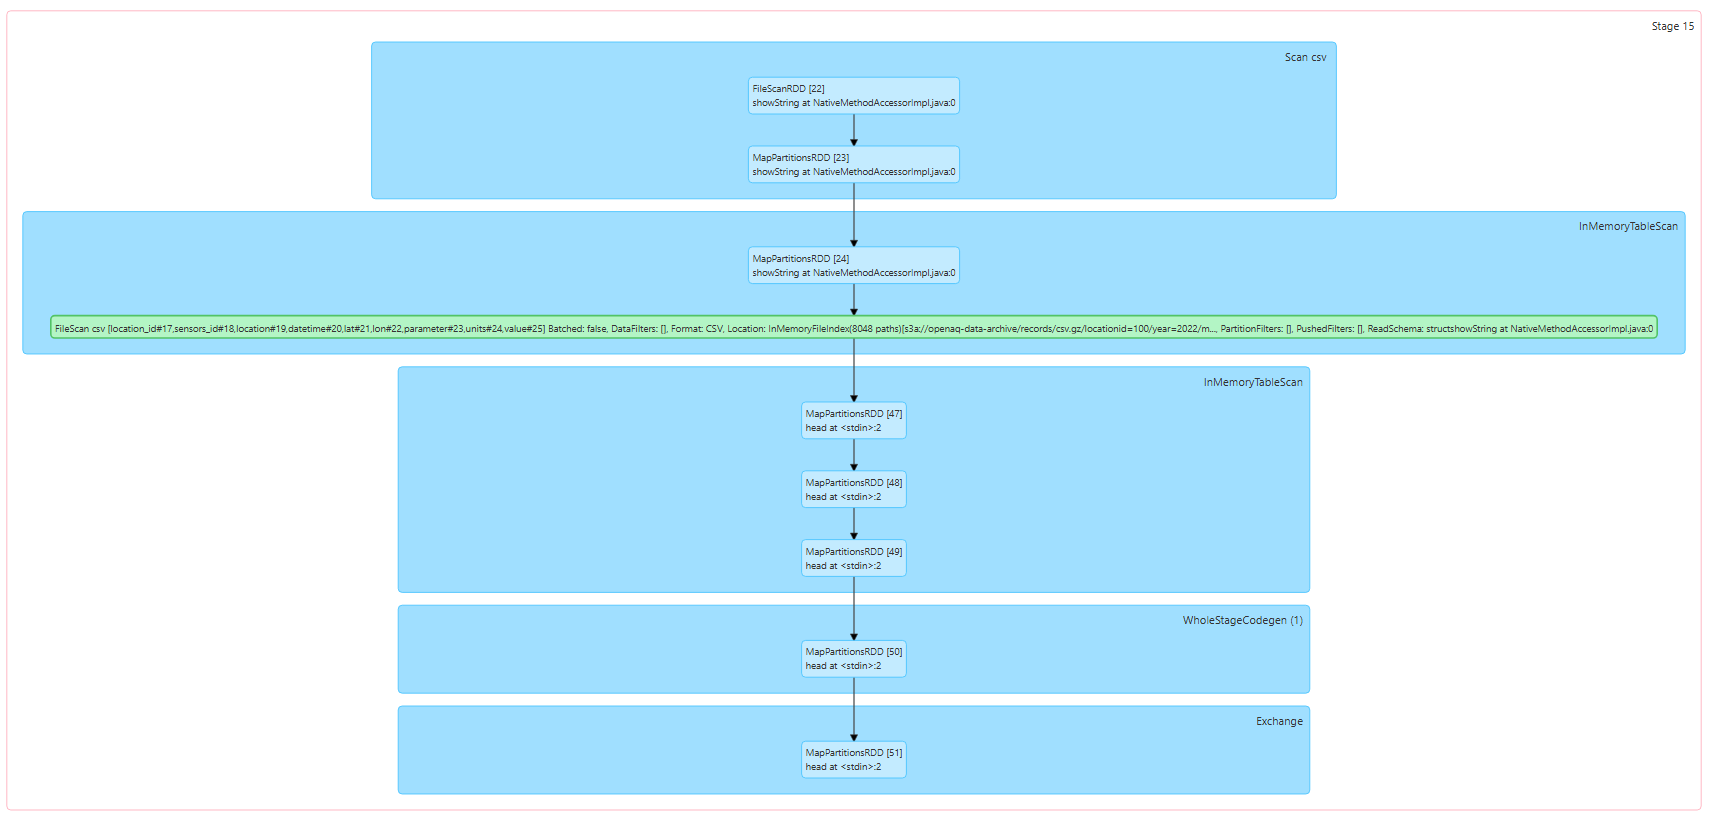

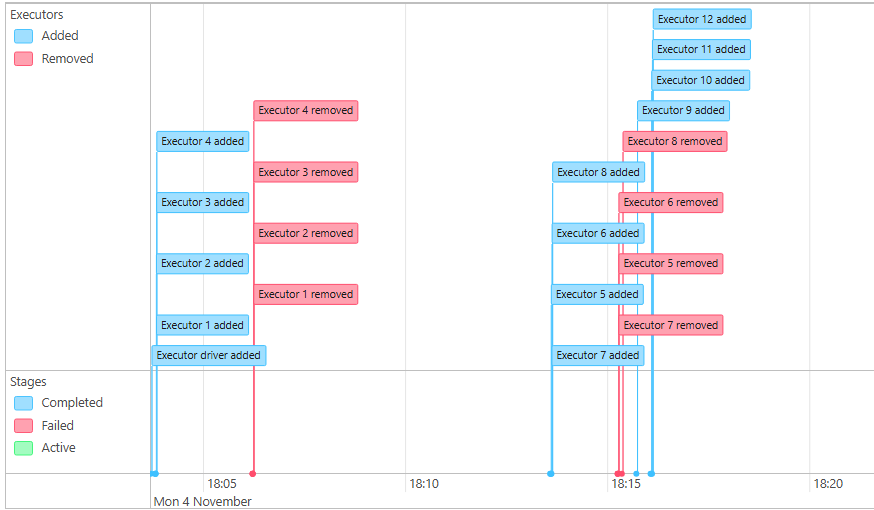

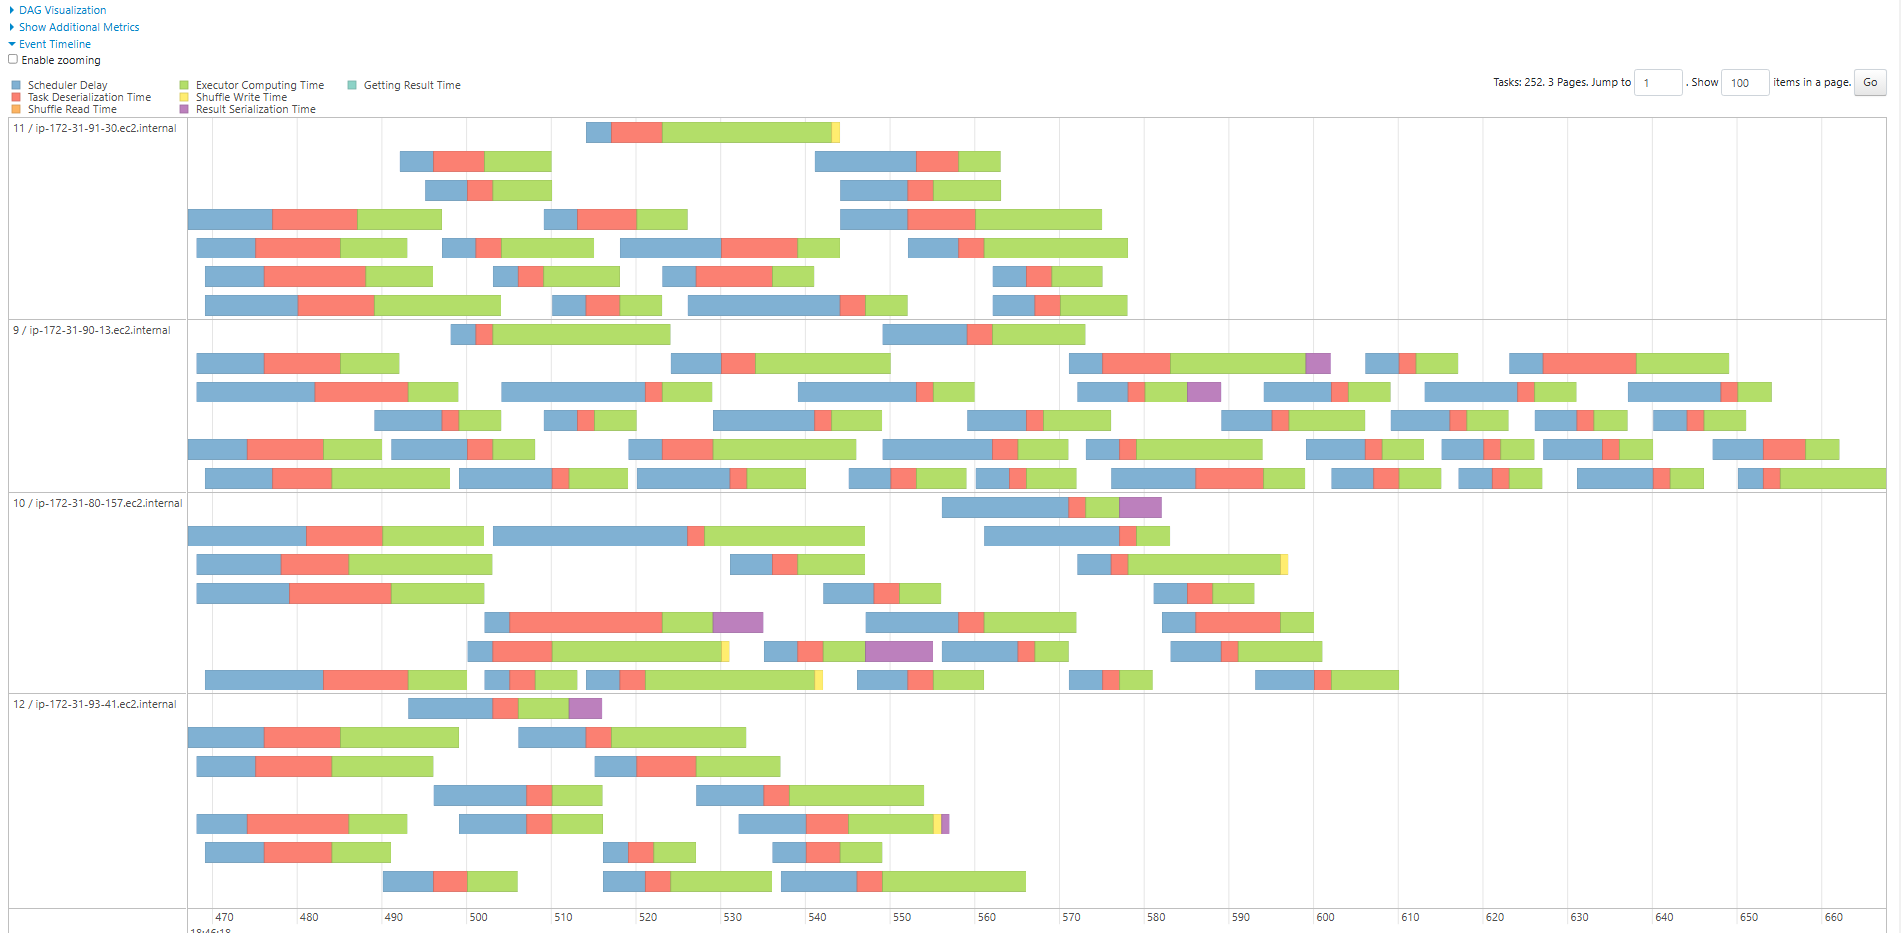

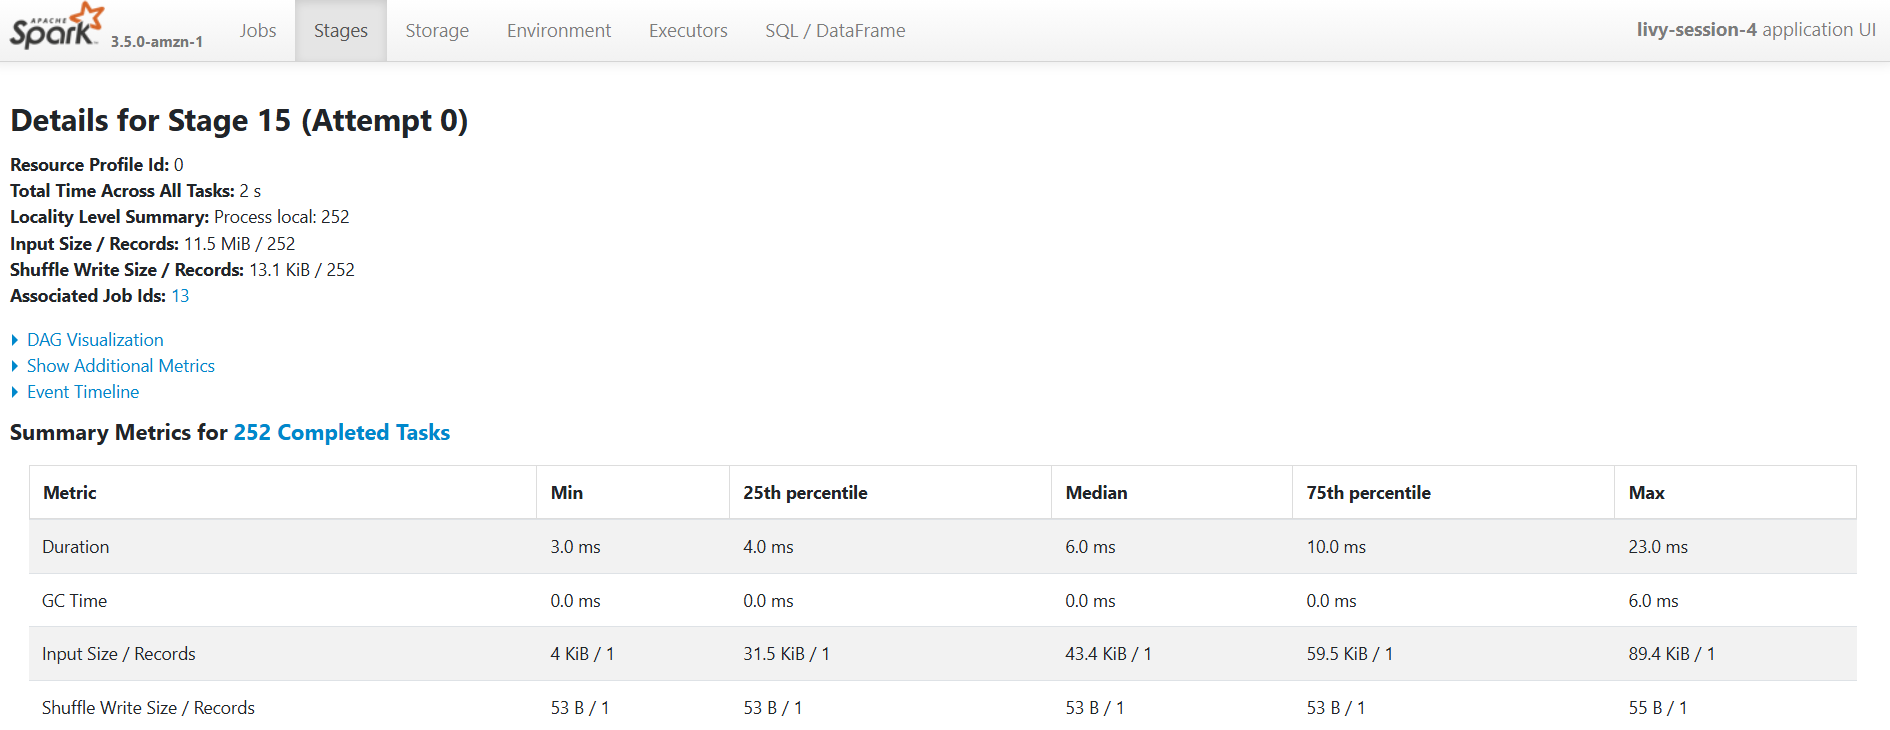